In [1]:
import os
import os.path as osp
from os.path import join as pjoin
import matplotlib.pyplot as plt
import numpy as np
import sbi
import pandas as pd
from tqdm import tqdm


In [26]:
lh_lookup = pd.read_csv('latin_hypercube_params_bonus.txt', 
                        delimiter=' ', header=None, names=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8'])
def theta_value(lhid):
    return lh_lookup.iloc[lhid+1].values

In [27]:
datapath = '/home/mattho/git/cmass-ili/data/borg-quijote/latin_hypercube_HR-L3000-N384'
simdirs = os.listdir(datapath)

Pktrain = []
thtrain = []
for s in tqdm(range(4,101)):
    pkpath = pjoin(datapath, str(s), 'Pk')
    if osp.isdir(pkpath):
        pklist = os.listdir(pkpath)
        out = [np.load(pjoin(pkpath, x)) for x in pklist]
        out = np.stack([np.array(list(x.values())) for x in out])
        
        k = out[0,0]
        Pk = out[:,1:,:].reshape(len(out), -1)
        Pktrain.append(Pk)
        thtrain.append([theta_value(s)]*len(Pk))

100%|██████████| 97/97 [00:02<00:00, 47.42it/s]


In [28]:
Pktrain = np.concatenate(Pktrain, axis=0)
thtrain = np.concatenate(thtrain, axis=0)

Pktrain[Pktrain<0] = 1
Pktrain = np.log10(Pktrain)

In [29]:
lhid = 1999
x0 = np.load('/home/mattho/git/cmass-ili/data/borg-quijote/latin_hypercube_HR-L3000-N384/1999/Pk/Pk0.npz')
x0 = np.array(list(x0.values()))[1:].reshape(1,-1)
thtest = np.array(theta_value(lhid))

x0[x0<0]=1
x0 = np.log10(x0)

In [30]:
x0.shape

(1, 213)

In [31]:
import torch
import numpy as np

from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNLE

In [32]:
tmin, tmax = thtrain.min(axis=0), thtrain.max(axis=0)
prior = utils.BoxUniform(low=tmin, high=tmax)

In [33]:
from sbi.inference import SNLE

inference = SNLE(prior)
thtrain = torch.Tensor(thtrain)
Pktrain = torch.Tensor(Pktrain)
likelihood_estimator = inference.append_simulations(thtrain, Pktrain).train()

 Neural network successfully converged after 466 epochs.

In [34]:
from sbi.inference import likelihood_estimator_based_potential, MCMCPosterior

potential_fn, parameter_transform = likelihood_estimator_based_potential(
    likelihood_estimator, prior, x0
)
posterior = MCMCPosterior(
    potential_fn, proposal=prior, theta_transform=parameter_transform,
    num_chains=60, num_workers=10, method='slice_np_vectorized'
)

In [35]:
t = posterior.sample(sample_shape=(1000,))

Generating 60 MCMC inits with 10
                         workers.: 100%|██████████| 60/60 [00:04<00:00, 14.07it/s]
/data80/mattho/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/sbi/samplers/mcmc/slice_numpy.py:394: UserWarning: Parallelization of vectorized slice sampling not implement, running
                serially.
  warn(
Running vectorized MCMC with 60 chains:  97%|█████████▋| 15600/16020 [01:15<00:02, 206.59it/s]


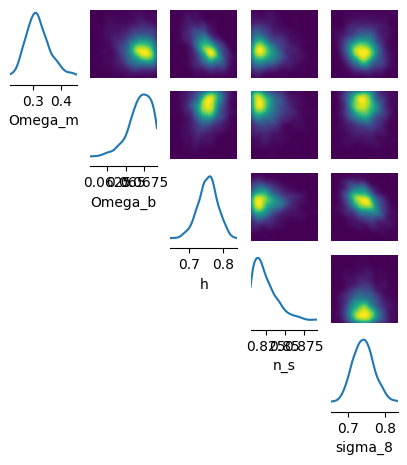

In [36]:
from sbi.analysis import pairplot

fig, ax = pairplot(
    samples=t,
#     limits=torch.tensor([[-2.0, 2.0]] * 3),
    upper=["kde"],
    diag=["kde"],
    figsize=(5, 5),
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
)

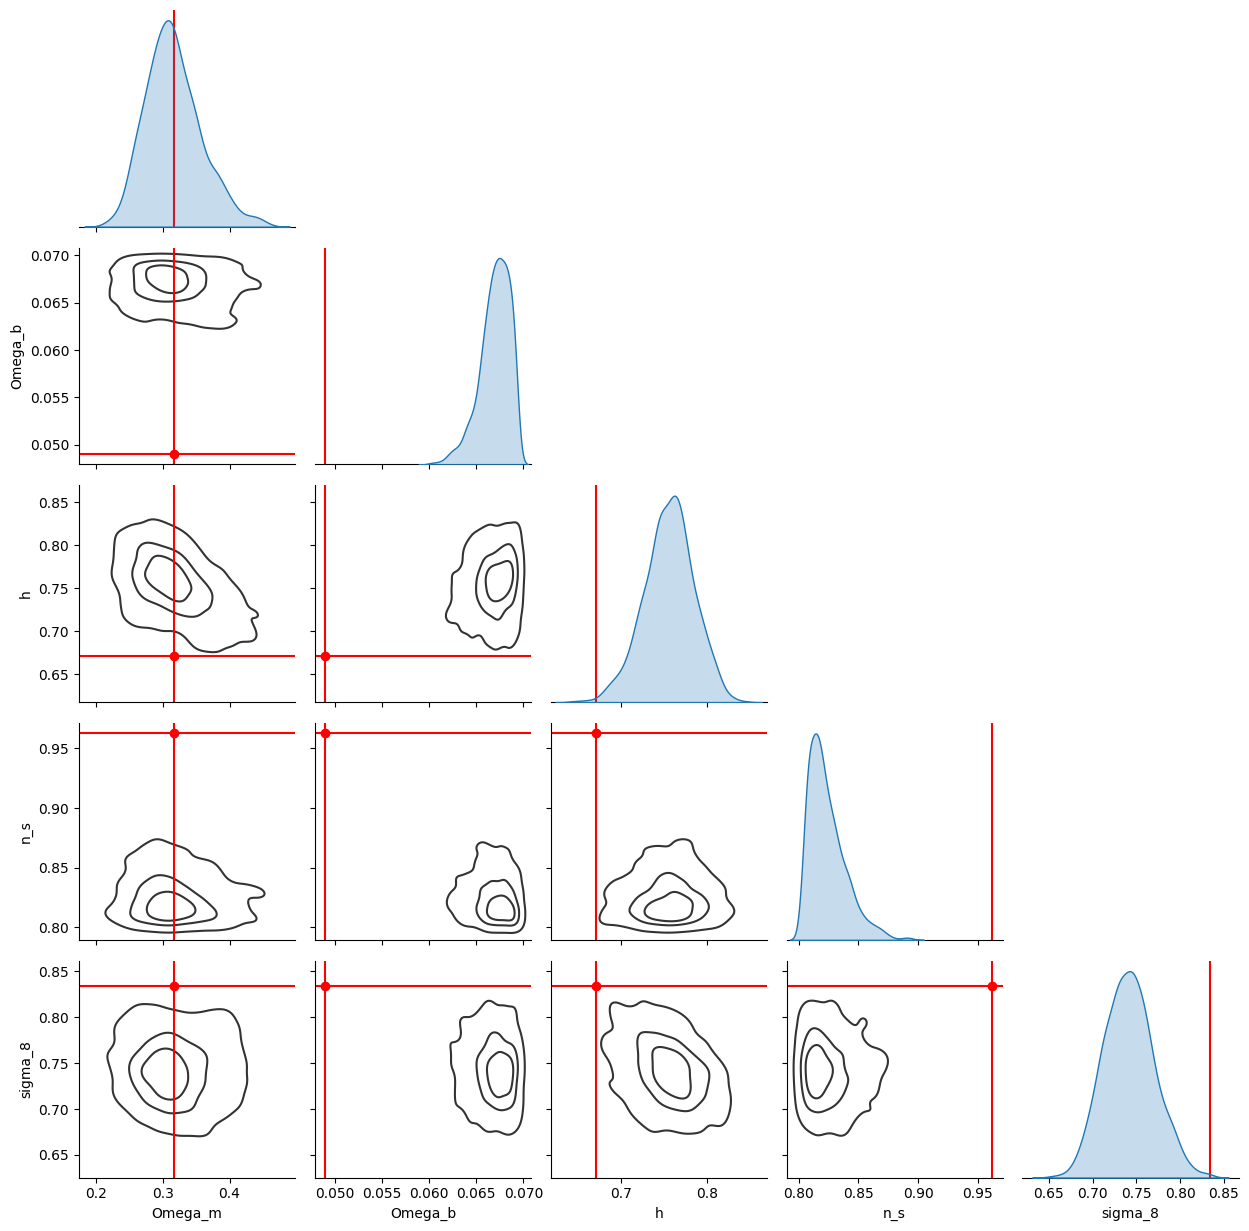

In [37]:
import seaborn as sns
labels = ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
theta_obs = thtest

g = sns.pairplot(
    pd.DataFrame(t, columns=labels),
    kind=None,
    diag_kind="kde",
    corner=True,
)
g.map_lower(sns.kdeplot, levels=4, color=".2")

ndim = len(theta_obs)
for i in range(ndim):
    for j in range(i + 1):
        if i == j:
            g.axes[i, i].axvline(theta_obs[i], color="r")
        else:
            g.axes[i, j].axhline(theta_obs[i], color="r")
            g.axes[i, j].axvline(theta_obs[j], color="r")
            g.axes[i, j].plot(theta_obs[j], theta_obs[i], "ro")

In [58]:
from sbi.inference import SNPE
from sbi.inference import DirectPosterior

inference = SNPE()
posterior_estimator = inference.append_simulations(thtrain, Pktrain).train()

 Neural network successfully converged after 33 epochs.

In [59]:
posterior = DirectPosterior(posterior_estimator, prior=prior).set_default_x(x0)

In [60]:
t = posterior.sample(sample_shape=(1000,))

Drawing 1000 posterior samples: 1266it [00:05, 243.66it/s]                         


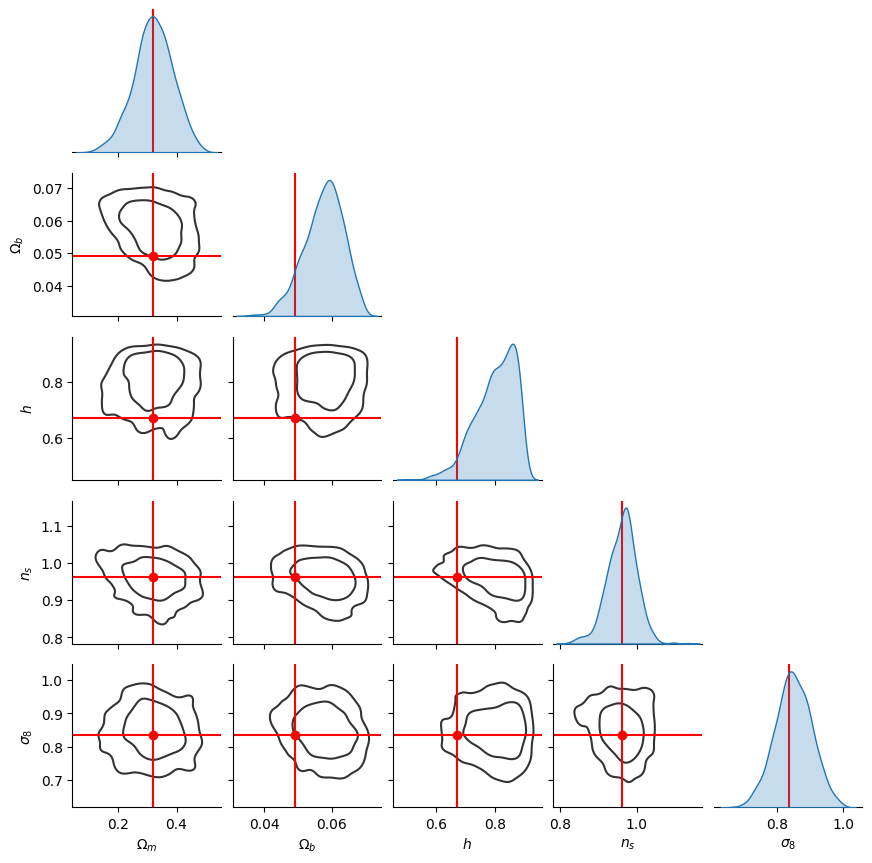

In [62]:
import seaborn as sns
labels = ['$\Omega_m$', '$\Omega_b$', '$h$', '$n_s$', '$\sigma_8$']
theta_obs = thtest

g = sns.pairplot(
    pd.DataFrame(t, columns=labels),
    kind=None,
    diag_kind="kde",
    corner=True,
    height=1.75
)
g.map_lower(sns.kdeplot, levels=[0.05,0.32], color=".2")

ndim = len(theta_obs)
for i in range(ndim):
    for j in range(i + 1):
#         g.axes[i,j].set_xlim(tmin[j], tmax[j])
        if i == j:
            g.axes[i, i].axvline(theta_obs[i], color="r")
        else:
            g.axes[i, j].axhline(theta_obs[i], color="r")
            g.axes[i, j].axvline(theta_obs[j], color="r")
            g.axes[i, j].plot(theta_obs[j], theta_obs[i], "ro")
g.savefig('images/fiducial_constraint.jpg', dpi=180)

In [63]:
tmin, tmax

(array([0.1005 , 0.03027, 0.5009 , 0.8043 , 0.6187 ]),
 array([0.4937 , 0.06929, 0.8961 , 1.1999 , 0.9961 ]))